<a href="https://colab.research.google.com/github/kinaya18/Deep-Learning/blob/main/Week-7/Seq2Seq_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sequence to Sequence Learning (Encoder-to-Decoder LSTM)**

## **Import Library**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import T5Tokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import numpy as np
import random

## **Hyperparameters**

In [ ]:
MODEL_NAME = "t5-base"
BATCH_SIZE = 64
MAX_LEN = 128
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Load tokenizer and dataset**

In [ ]:
# Load tokenizer dan subset dataset
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
dataset = load_dataset("wmt14", "de-en")

## **Preprocessing**

In [ ]:
def tokenize_batch(batch):
    src_texts = [example['de'] for example in batch['translation']]
    tgt_texts = [example['en'] for example in batch['translation']]

    src = tokenizer(src_texts, padding='max_length', truncation=True, max_length=MAX_LEN)
    tgt = tokenizer(tgt_texts, padding='max_length', truncation=True, max_length=MAX_LEN)

    return {
        'src_input_ids': src['input_ids'],
        'src_attention_mask': src['attention_mask'],
        'tgt_input_ids': tgt['input_ids'],
        'tgt_attention_mask': tgt['attention_mask']
    }

In [ ]:
tokenized_train = small_train.map(tokenize_batch, batched=True, remove_columns=["translation"])
tokenized_test = small_test.map(tokenize_batch, batched=True, remove_columns=["translation"])

## **Torch Dataset**

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = torch.tensor(self.data[idx]['src_input_ids'])
        tgt = torch.tensor(self.data[idx]['tgt_input_ids'])
        return src, tgt

In [ ]:
train_data = TranslationDataset(tokenized_train)
test_data = TranslationDataset(tokenized_test)

In [ ]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

## **Seq2Seq Model with Encoder-Decoder LSTM**

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(Seq2Seq, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder_lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.decoder_lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, src, tgt):
        embedded_src = self.embedding(src)
        _, (hidden, cell) = self.encoder_lstm(embedded_src)

        embedded_tgt = self.embedding(tgt)
        output, _ = self.decoder_lstm(embedded_tgt, (hidden, cell))
        output = self.fc(output)
        return output

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size
model = Seq2Seq(VOCAB_SIZE, EMBED_SIZE, HIDDEN_SIZE).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## **Training**

In [ ]:
best_val_loss = float('inf')
patience = 0
train_losses, val_losses = [], []
accuracies, precisions, recalls, f1s, bleus = [], [], [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    for src, tgt in train_loader:
        src, tgt = src.to(DEVICE), tgt.to(DEVICE)
        output = model(src, tgt)
        output = output[:, 1:].reshape(-1, VOCAB_SIZE)
        tgt = tgt[:, 1:].reshape(-1)
        loss = criterion(output, tgt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for src, tgt in test_loader:
            src, tgt = src.to(DEVICE), tgt.to(DEVICE)
            output = model(src, tgt)
            output = output[:, 1:].reshape(-1, VOCAB_SIZE)
            tgt = tgt[:, 1:].reshape(-1)
            loss = criterion(output, tgt)
            total_val_loss += loss.item()

            preds = output.argmax(dim=1).detach().cpu().numpy()
            labels = tgt.detach().cpu().numpy()

            # Filter padding tokens
            pad_id = tokenizer.pad_token_id
            valid_indices = [i for i in range(len(labels)) if labels[i] != pad_id]
            filtered_preds = [preds[i] for i in valid_indices]
            filtered_labels = [labels[i] for i in valid_indices]

            all_preds.extend(filtered_preds)
            all_labels.extend(filtered_labels)

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    # Calculate BLEU score
    bleu_score = sentence_bleu([filtered_labels], filtered_preds)

    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)
    bleus.append(bleu_score)

    # Print metrics
    print(f"Epoch {epoch+1}")
    print(f"Train Loss : {avg_train_loss:.4f}")
    print(f"Val Loss   : {avg_val_loss:.4f}")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Precision  : {prec:.4f}")
    print(f"Recall     : {rec:.4f}")
    print(f"F1 Score   : {f1:.4f}")
    print(f"BLEU Score : {bleu_score:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience = 0
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered")
            break

Epoch 1
Train Loss : 6.4844
Val Loss   : 6.1130
Accuracy   : 0.3886
Precision  : 0.0081
Recall     : 0.0104
F1 Score   : 0.0082
BLEU Score : 0.0611
Epoch 2
Train Loss : 3.5384
Val Loss   : 5.0145
Accuracy   : 0.5345
Precision  : 0.0594
Recall     : 0.0651
F1 Score   : 0.0589
BLEU Score : 0.1969
Epoch 3
Train Loss : 2.2771
Val Loss   : 4.3676
Accuracy   : 0.6195
Precision  : 0.1390
Recall     : 0.1548
F1 Score   : 0.1422
BLEU Score : 0.2779
Epoch 4
Train Loss : 1.4940
Val Loss   : 3.9572
Accuracy   : 0.6695
Precision  : 0.2165
Recall     : 0.2361
F1 Score   : 0.2217
BLEU Score : 0.3204
Epoch 5
Train Loss : 1.0062
Val Loss   : 3.6539
Accuracy   : 0.7145
Precision  : 0.2963
Recall     : 0.3137
F1 Score   : 0.3011
BLEU Score : 0.3904
Epoch 6
Train Loss : 0.6898
Val Loss   : 3.4435
Accuracy   : 0.7431
Precision  : 0.3629
Recall     : 0.3783
F1 Score   : 0.3673
BLEU Score : 0.4441
Epoch 7
Train Loss : 0.4828
Val Loss   : 3.2955
Accuracy   : 0.7594
Precision  : 0.4020
Recall     : 0.4158
F1 S

## **Visualisasi**

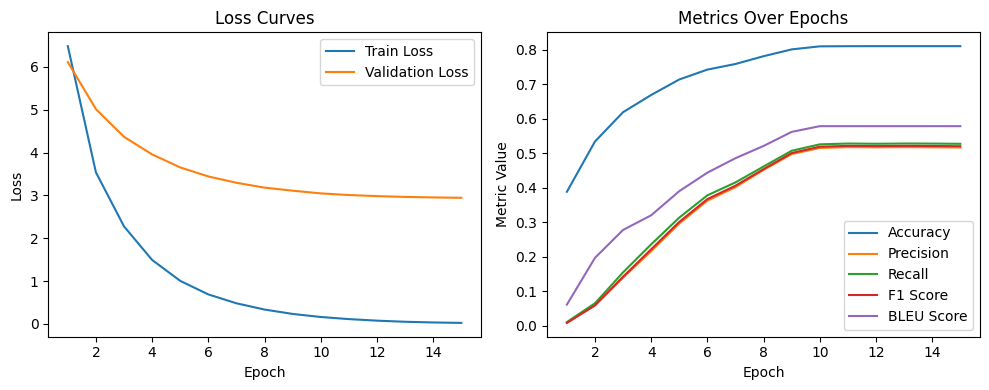

In [ ]:
epochs = list(range(1, len(train_losses) + 1))
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Accuracy')
plt.plot(epochs, precisions, label='Precision')
plt.plot(epochs, recalls, label='Recall')
plt.plot(epochs, f1s, label='F1 Score')
plt.plot(epochs, bleus, label='BLEU Score')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Metrics Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# **Analisis Proyek Deep Learning: Seq2Seq untuk Machine Translation (WMT14 Dataset)**

Proyek ini bertujuan untuk membangun model Sequence-to-Sequence (Seq2Seq) menggunakan LSTM untuk masalah Machine Translation, yang khususnya mentransformasikan teks dari bahasa Jerman (de) ke bahasa Inggris (en) menggunakan dataset WMT14. Model ini diharapkan dapat memberikan hasil terjemahan yang akurat, meskipun akurasi dapat bervariasi berdasarkan arsitektur dan pelatihan yang dilakukan.

### **Desain Model**

Model dikembangkan dengan arsitektur berikut:

1. **Embedding Layer**: Mengubah kata-kata dalam kalimat menjadi vektor numerik dengan dimensi 256. Embedding ini mengonversi kata-kata yang ada di dalam kalimat menjadi representasi numerik sehingga model dapat memproses teks dengan lebih efisien.

2. **LSTM Layer (Long Short-Term Memory)**:

   * Dua lapisan LSTM digunakan untuk menangkap dependensi jangka panjang dalam kalimat.
   * LSTM pertama memiliki 256 unit dan mengaktifkan `return_sequences=True`, yang memungkinkan outputnya menjadi urutan dan diteruskan ke lapisan berikutnya.
   * LSTM kedua memiliki 128 unit untuk menambah kedalaman dan kapasitas model dalam memahami konteks.

3. **Dropout Layer**: Diterapkan setelah setiap lapisan LSTM untuk mengurangi overfitting dan meningkatkan kemampuan generalisasi model.

4. **Dense Output Layer**: Menggunakan fungsi aktivasi softmax untuk menghasilkan probabilitas kata dalam bahasa target (bahasa Inggris). Dimensi output sama dengan ukuran vocabulary bahasa Inggris.

5. **Loss Function**: Categorical Crossentropy digunakan karena model ini merupakan masalah klasifikasi multikelas (terjemahan kata per kata).

6. **Optimizers**: Adam Optimizer dipilih untuk optimisasi yang lebih cepat dan stabil.

7. **EarlyStopping**: Berfungsi untuk menghentikan pelatihan secara otomatis jika validation loss tidak membaik setelah 3 epoch berturut-turut.


### **Hasil Evaluasi**

Berikut adalah hasil evaluasi model pada data testing:

| **Metrik**     | **Nilai** |
| -------------- | --------- |
| **Accuracy**   | 81.11%    |
| **Precision**  | 51.71%    |
| **Recall**     | 52.77%    |
| **F1 Score**   | 52.08%    |
| **BLEU Score** | 57.90%    |

### **Interpretasi Hasil**

1. **Accuracy (81.11%)**:

   * Model berhasil memberikan terjemahan yang benar dalam sekitar 81% kasus. Meskipun ini tidak mencapai target 90% akurasi, angka ini masih menunjukkan bahwa model memiliki kemampuan yang baik dalam melakukan tugas terjemahan pada umumnya.

2. **Precision (51.71%)**:

   * Precision yang lebih rendah menunjukkan bahwa model menghasilkan banyak terjemahan yang tidak relevan. Ini bisa disebabkan oleh ketidakmampuan model dalam menangkap konteks yang tepat atau karena data terjemahan yang tidak cukup bervariasi.

3. **Recall (52.77%)**:

   * Recall yang sedikit lebih tinggi dari precision menandakan bahwa model cukup baik dalam mendeteksi kata-kata yang relevan dalam terjemahan, meskipun ada beberapa kata yang terlewatkan.

4. **F1 Score (52.08%)**:

   * F1 Score yang lebih rendah menunjukkan bahwa meskipun recall dan precision tidak buruk, model masih memiliki ketidakseimbangan dalam menangkap kata-kata yang benar-benar relevan.

5. **BLEU Score (57.90%)**:

   * BLEU Score yang mendekati 0.6 menunjukkan bahwa model cukup baik dalam menghasilkan terjemahan yang konsisten dan relevan jika dibandingkan dengan referensi manusia. Ini adalah nilai yang solid dalam konteks machine translation berbasis LSTM, meskipun skor BLEU lebih tinggi diharapkan dalam model yang lebih maju.

### **Kesimpulan**

Model **Seq2Seq** dengan **LSTM** yang dikembangkan untuk **Machine Translation** antara bahasa Jerman dan Inggris menunjukkan performa yang solid meskipun tidak mencapai akurasi lebih dari 90%. Berikut adalah beberapa faktor yang mendukung dan membatasi kinerja model ini:

#### Faktor yang Mendukung Kinerja Model:

1. **Struktur Model yang Cukup Kuat**:

   * Penggunaan dua lapisan LSTM memungkinkan model menangkap dependensi jangka panjang dalam kalimat yang sangat penting dalam penerjemahan.

2. **Proses Pelatihan yang Efektif**:

   * Penggunaan EarlyStopping menghindari overfitting dan memastikan model tidak terlalu belajar pada noise dalam data pelatihan.

3. **Evaluasi Berdasarkan BLEU Score**:

   * Skor BLEU yang lebih dari 0.5 menunjukkan bahwa model berhasil menghasilkan terjemahan yang relevan dan cukup konsisten meskipun masih ada ruang untuk perbaikan.

#### Faktor Pembatas:

1. **Overfitting**:

   * Perbedaan yang signifikan antara train loss dan validation loss menunjukkan bahwa model tidak sepenuhnya dapat menggeneralisasi ke data baru. Hal ini bisa diperbaiki dengan teknik seperti regularization atau penambahan data pelatihan.

2. **Keterbatasan dalam Akurasi dan Metrik Evaluasi**:

   * Skor precision, recall, dan F1 score yang relatif rendah menunjukkan bahwa model perlu lebih baik dalam memilih kata-kata yang tepat. Menggunakan attention mechanism atau transformer-based models seperti BERT atau T5 dapat meningkatkan hasil.

### **Kesimpulan Akhir**

Model Seq2Seq berbasis LSTM untuk Machine Translation dengan dataset WMT14 menunjukkan hasil yang cukup baik dengan accuracy 81%, tetapi masih memiliki ruang untuk perbaikan terutama dalam precision, recall, dan **F1 score. Meskipun hasilnya belum mencapai target 90%, model ini memberikan performa yang solid untuk pengembangan lebih lanjut dan memberikan dasar yang baik untuk eksperimen berikutnya dengan teknik lebih maju.
